In [39]:
!pip install pmdarima
!pip install prophet
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# For SARIMA Model
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import warnings
# Suppressing the  warnings
warnings.filterwarnings("ignore")

In [43]:
Sales_dataset = pd.read_csv(r"C:\Users\navee\OneDrive\Desktop\pizza_price_prediction\Pizza_Sale - pizza_sales.csv")
Ingredients_dataset = pd.read_csv(r"C:\Users\navee\OneDrive\Desktop\pizza_price_prediction\Pizza_ingredients - Pizza_ingredients.csv")

In [45]:
Sales_dataset.head()

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [47]:
Sales_dataset.shape

(48620, 12)

In [49]:
Sales_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB


In [51]:
Ingredients_dataset.head()

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [53]:
Ingredients_dataset.shape

(518, 4)

In [55]:
Ingredients_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB


In [57]:
Sales_dataset.isna().sum()

pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64

In [59]:
Sales_dataset['total_price'].fillna(Sales_dataset['unit_price'] * Sales_dataset['quantity'], inplace=True)

In [61]:
Sales_dataset['pizza_category'].value_counts()

pizza_category
Classic    14572
Supreme    11771
Veggie     11442
Chicken    10812
Name: count, dtype: int64

In [63]:
Sales_dataset[Sales_dataset['pizza_category'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
426,427,181,mexicana_l,1,3/1/2015,18:49:32,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
427,428,182,brie_carre_s,1,3/1/2015,18:50:10,23.65,23.65,S,NaN,"Brie Carre Cheese, Prosciutto, Caramelized Oni...",The Brie Carre Pizza
428,429,182,peppr_salami_l,1,3/1/2015,18:50:10,20.75,20.75,L,NaN,"Genoa Salami, Capocollo, Pepperoni, Tomatoes, ...",The Pepper Salami Pizza
429,430,183,napolitana_m,1,3/1/2015,18:54:55,16.00,16.00,M,NaN,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
430,431,183,spin_pesto_l,1,3/1/2015,18:54:55,20.75,20.75,L,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza
431,432,183,spin_pesto_s,1,3/1/2015,18:54:55,12.50,12.50,S,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza
432,433,184,hawaiian_l,1,3/1/2015,18:59:05,16.50,16.50,L,NaN,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
433,434,185,sicilian_m,1,3/1/2015,19:08:33,16.25,16.25,M,NaN,"Coarse Sicilian Salami, Tomatoes, Green Olives...",The Sicilian Pizza
434,435,185,spin_pesto_s,1,3/1/2015,19:08:33,12.50,12.50,S,NaN,"Spinach, Artichokes, Tomatoes, Sun-dried Tomat...",The Spinach Pesto Pizza
435,436,186,mexicana_l,1,3/1/2015,19:36:00,20.25,20.25,L,NaN,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [65]:
Sales_dataset['pizza_name_id'].value_counts()

pizza_name_id
big_meat_s        1811
thai_ckn_l        1363
five_cheese_l     1358
four_cheese_l     1272
classic_dlx_m     1159
                  ... 
mexicana_s         160
calabrese_s         99
ckn_alfredo_s       96
green_garden_l      94
the_greek_xxl       28
Name: count, Length: 91, dtype: int64

In [67]:
category_mapping = Sales_dataset[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()
category_mapping = category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()

In [69]:
Sales_dataset['pizza_category'] = Sales_dataset['pizza_category'].fillna(Sales_dataset['pizza_name_id'].map(category_mapping))

In [71]:
Sales_dataset[Sales_dataset['pizza_category'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name


In [73]:
Sales_dataset[Sales_dataset['pizza_ingredients'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
580,581,254,five_cheese_l,1,4/1/2015,22:22:13,18.50,18.50,L,Veggie,NaN,The Five Cheese Pizza
581,582,255,five_cheese_l,1,5/1/2015,11:23:35,18.50,18.50,L,Veggie,NaN,The Five Cheese Pizza
582,583,255,green_garden_m,1,5/1/2015,11:23:35,16.00,16.00,M,Veggie,NaN,The Green Garden Pizza
583,584,255,hawaiian_l,1,5/1/2015,11:23:35,16.50,16.50,L,Classic,NaN,The Hawaiian Pizza
584,585,255,spinach_fet_m,1,5/1/2015,11:23:35,16.00,16.00,M,Veggie,NaN,The Spinach and Feta Pizza
585,586,256,pep_msh_pep_l,1,5/1/2015,11:56:06,17.50,17.50,L,Classic,NaN,"The Pepperoni, Mushroom, and Peppers Pizza"
586,587,257,cali_ckn_l,1,5/1/2015,11:59:04,20.75,20.75,L,Chicken,NaN,The California Chicken Pizza
630,631,277,four_cheese_m,1,5/1/2015,15:41:50,14.75,14.75,M,Veggie,NaN,The Four Cheese Pizza
631,632,278,ital_veggie_m,1,5/1/2015,15:49:21,16.75,16.75,M,Veggie,NaN,The Italian Vegetables Pizza
632,633,278,southw_ckn_l,1,5/1/2015,15:49:21,20.75,20.75,L,Chicken,NaN,The Southwest Chicken Pizza


In [75]:
ingredients_mapping = Sales_dataset[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
ingredients_mapping = ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()

In [77]:
Sales_dataset['pizza_ingredients'] = Sales_dataset['pizza_ingredients'].fillna(Sales_dataset['pizza_name'].map(ingredients_mapping))

In [79]:
Sales_dataset[Sales_dataset['pizza_ingredients'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name


In [81]:
Sales_dataset[Sales_dataset['pizza_name'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
688,689,303,pepperoni_s,1,5/1/2015,20:02:51,9.75,9.75,S,Classic,"Mozzarella Cheese, Pepperoni",NaN
689,690,304,hawaiian_s,1,5/1/2015,20:07:58,10.50,10.50,S,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",NaN
690,691,304,mexicana_l,1,5/1/2015,20:07:58,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",NaN
691,692,305,pepperoni_l,1,5/1/2015,20:35:40,15.25,15.25,L,Classic,"Mozzarella Cheese, Pepperoni",NaN
692,693,305,sicilian_s,1,5/1/2015,20:35:40,12.25,12.25,S,Supreme,"Coarse Sicilian Salami, Tomatoes, Green Olives...",NaN
693,694,305,spicy_ital_m,1,5/1/2015,20:35:40,16.50,16.50,M,Supreme,"Capocollo, Tomatoes, Goat Cheese, Artichokes, ...",NaN
694,695,306,big_meat_s,1,5/1/2015,20:37:40,12.00,12.00,S,Classic,"Bacon, Pepperoni, Italian Sausage, Chorizo Sau...",NaN


In [83]:
len(Sales_dataset['pizza_ingredients'].value_counts())

32

In [85]:
ingredients_name_mapping = Sales_dataset[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
ingredients_name_mapping = ingredients_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()

Sales_dataset['pizza_name'] = Sales_dataset['pizza_name'].fillna(Sales_dataset['pizza_ingredients'].map(ingredients_name_mapping))

In [87]:
Sales_dataset[Sales_dataset['pizza_name'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name


In [89]:
name_id_mapping = Sales_dataset[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
name_id_mapping = name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()

Sales_dataset['pizza_name_id'] = Sales_dataset['pizza_name_id'].fillna(Sales_dataset['pizza_name'].map(name_id_mapping))

In [91]:
Sales_dataset[Sales_dataset['pizza_name_id'].isna()]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name


In [93]:
Sales_dataset.isna().sum()

pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

**Ingredients_dataset**

In [95]:
Ingredients_dataset.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64

In [97]:
Ingredients_dataset[Ingredients_dataset['Items_Qty_In_Grams'].isna()]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [99]:
Ingredients_dataset[Ingredients_dataset['pizza_name']=='The Brie Carre Pizza']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
22,brie_carre_s,The Brie Carre Pizza,Brie Carre Cheese,30.0
23,brie_carre_s,The Brie Carre Pizza,Prosciutto,30.0
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
25,brie_carre_s,The Brie Carre Pizza,Pears,10.0
26,brie_carre_s,The Brie Carre Pizza,Thyme,5.0
27,brie_carre_s,The Brie Carre Pizza,Garlic,5.0


In [101]:
Ingredients_dataset[Ingredients_dataset['pizza_ingredients']=='Sliced Ham']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [103]:
Ingredients_dataset[Ingredients_dataset['pizza_name_id']=='hawaiian_l']

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
150,hawaiian_l,The Hawaiian Pizza,Pineapple,45.0
151,hawaiian_l,The Hawaiian Pizza,Mozzarella Cheese,30.0


In [105]:
mean_qty = Ingredients_dataset.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()

In [107]:
mean_qty

pizza_name_id
bbq_ckn_l        30.000000
bbq_ckn_m        20.833333
bbq_ckn_s        13.333333
big_meat_s       65.000000
brie_carre_s     16.000000
                   ...    
the_greek_xl     61.666667
the_greek_xxl    80.000000
veggie_veg_l     34.375000
veggie_veg_m     23.125000
veggie_veg_s     13.125000
Name: Items_Qty_In_Grams, Length: 91, dtype: float64

In [109]:
Ingredients_dataset['Items_Qty_In_Grams'] = Ingredients_dataset['Items_Qty_In_Grams'].fillna(Ingredients_dataset['pizza_name_id'].map(mean_qty))

In [111]:
remaining_missing_qty = Ingredients_dataset['Items_Qty_In_Grams'].isna().sum()
print(f"Remaining missing Items_Qty_In_Grams: {remaining_missing_qty}")

Remaining missing Items_Qty_In_Grams: 0


In [113]:
Ingredients_dataset.isna().sum()

pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    0
dtype: int64

In [115]:
merged_data = pd.merge(Sales_dataset, Ingredients_dataset, on='pizza_name_id', how='left')

In [117]:
merged_data

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267571,48620,21350,bbq_ckn_s,1,31-12-2015,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,The Barbecue Chicken Pizza,Red Peppers,5.0
267572,48620,21350,bbq_ckn_s,1,31-12-2015,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,The Barbecue Chicken Pizza,Green Peppers,20.0
267573,48620,21350,bbq_ckn_s,1,31-12-2015,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,The Barbecue Chicken Pizza,Tomatoes,10.0
267574,48620,21350,bbq_ckn_s,1,31-12-2015,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,The Barbecue Chicken Pizza,Red Onions,20.0


In [119]:
merged_data.shape

(267576, 15)

In [121]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267576 entries, 0 to 267575
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   pizza_id             267576 non-null  int64  
 1   order_id             267576 non-null  int64  
 2   pizza_name_id        267576 non-null  object 
 3   quantity             267576 non-null  int64  
 4   order_date           267576 non-null  object 
 5   order_time           267576 non-null  object 
 6   unit_price           267576 non-null  float64
 7   total_price          267576 non-null  float64
 8   pizza_size           267576 non-null  object 
 9   pizza_category       267576 non-null  object 
 10  pizza_ingredients_x  267576 non-null  object 
 11  pizza_name_x         267576 non-null  object 
 12  pizza_name_y         267576 non-null  object 
 13  pizza_ingredients_y  267576 non-null  object 
 14  Items_Qty_In_Grams   267576 non-null  float64
dtypes: float64(3), in

In [123]:
merged_data.isnull().sum()

pizza_id               0
order_id               0
pizza_name_id          0
quantity               0
order_date             0
order_time             0
unit_price             0
total_price            0
pizza_size             0
pizza_category         0
pizza_ingredients_x    0
pizza_name_x           0
pizza_name_y           0
pizza_ingredients_y    0
Items_Qty_In_Grams     0
dtype: int64

In [125]:
merged_data[['pizza_ingredients_x','pizza_ingredients_y']]

,pizza_ingredients_x,pizza_ingredients_y
0,"Sliced Ham, Pineapple, Mozzarella Cheese",Sliced Ham
1,"Sliced Ham, Pineapple, Mozzarella Cheese",Pineapple
2,"Sliced Ham, Pineapple, Mozzarella Cheese",Mozzarella Cheese
3,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Pepperoni
4,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",Mushrooms
...,...,...
267571,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Peppers
267572,"Barbecued Chicken, Red Peppers, Green Peppers,...",Green Peppers
267573,"Barbecued Chicken, Red Peppers, Green Peppers,...",Tomatoes
267574,"Barbecued Chicken, Red Peppers, Green Peppers,...",Red Onions


In [127]:
merged_data[['pizza_name_x','pizza_name_y']]

,pizza_name_x,pizza_name_y
0,The Hawaiian Pizza,The Hawaiian Pizza
1,The Hawaiian Pizza,The Hawaiian Pizza
2,The Hawaiian Pizza,The Hawaiian Pizza
3,The Classic Deluxe Pizza,The Classic Deluxe Pizza
4,The Classic Deluxe Pizza,The Classic Deluxe Pizza
...,...,...
267571,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267572,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267573,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza
267574,The Barbecue Chicken Pizza,The Barbecue Chicken Pizza


In [129]:
merged_data.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_data.rename(columns={'pizza_name_x': 'pizza_name','pizza_ingredients_x': 'pizza_ingredients'}, inplace=True)

In [131]:
merged_data.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name',
       'Items_Qty_In_Grams'],
      dtype='object')

In [133]:
merged_data.isna().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
dtype: int64

In [135]:
merged_data.duplicated().sum()

80204

In [137]:
merged_data = merged_data.drop_duplicates()

In [139]:
merged_data.duplicated().sum()

0

In [141]:
merged_data.shape[0]

187372

In [143]:
merged_data1 = merged_data.copy()

In [145]:
merged_data1.to_csv(r"C:\Users\navee\OneDrive\Desktop\pizza_price_prediction\merged_data1.csv", index=False)

In [147]:
merged_data = pd.read_csv(r"C:\Users\navee\OneDrive\Desktop\pizza_price_prediction\merged_data1.csv")

In [149]:
merged_data.describe()

,pizza_id,order_id,quantity,unit_price,total_price,Items_Qty_In_Grams
count,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000,187372.000000
mean,24312.676030,10702.312405,1.019250,16.914338,17.244843,37.645900
std,14039.560378,6181.841091,0.141575,3.571451,4.419979,35.729459
min,1.000000,1.000000,1.000000,9.750000,9.750000,5.000000
25%,12166.750000,5344.000000,1.000000,12.750000,12.750000,15.000000
50%,24266.000000,10661.000000,1.000000,16.750000,16.750000,20.000000
75%,36494.250000,16112.250000,1.000000,20.500000,20.750000,45.000000
max,48620.000000,21350.000000,4.000000,35.950000,83.000000,200.000000


In [151]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187372 entries, 0 to 187371
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pizza_id            187372 non-null  int64  
 1   order_id            187372 non-null  int64  
 2   pizza_name_id       187372 non-null  object 
 3   quantity            187372 non-null  int64  
 4   order_date          187372 non-null  object 
 5   order_time          187372 non-null  object 
 6   unit_price          187372 non-null  float64
 7   total_price         187372 non-null  float64
 8   pizza_size          187372 non-null  object 
 9   pizza_category      187372 non-null  object 
 10  pizza_ingredients   187372 non-null  object 
 11  pizza_name          187372 non-null  object 
 12  Items_Qty_In_Grams  187372 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 18.6+ MB


**Feature Exploration and Engineering**

In [154]:
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

# Applying the function to the 'order_date' column
merged_data['order_date'] = merged_data['order_date'].apply(extract_date)

In [155]:
merged_data['day_of_week'] = merged_data['order_date'].dt.dayofweek 
merged_data['month'] = merged_data['order_date'].dt.month 
merged_data['week'] = merged_data['order_date'].dt.isocalendar().week
merged_data['year'] = merged_data['order_date'].dt.year

In [156]:
merged_data

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015
4,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187367,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,60.0,3,12,53,2015
187368,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,100.0,3,12,53,2015
187369,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,20.0,3,12,53,2015
187370,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,5.0,3,12,53,2015


In [162]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187372 entries, 0 to 187371
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pizza_id            187372 non-null  int64         
 1   order_id            187372 non-null  int64         
 2   pizza_name_id       187372 non-null  object        
 3   quantity            187372 non-null  int64         
 4   order_date          187372 non-null  datetime64[ns]
 5   order_time          187372 non-null  object        
 6   unit_price          187372 non-null  float64       
 7   total_price         187372 non-null  float64       
 8   pizza_size          187372 non-null  object        
 9   pizza_category      187372 non-null  object        
 10  pizza_ingredients   187372 non-null  object        
 11  pizza_name          187372 non-null  object        
 12  Items_Qty_In_Grams  187372 non-null  float64       
 13  day_of_week         187372 no

In [164]:
!pip install holidays

Defaulting to user installation because normal site-packages is not writeable


In [165]:
import holidays
us_holidays = holidays.US()
merged_data['holiday'] = merged_data['order_date'].apply(lambda x: 1 if x in us_holidays else 0)
merged_data[['order_date', 'holiday']].head()

,order_date,holiday
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
4,2015-01-01,1


In [168]:
merged_data[['order_date', 'holiday']]

,order_date,holiday
0,2015-01-01,1
1,2015-01-01,1
2,2015-01-01,1
3,2015-01-01,1
4,2015-01-01,1
...,...,...
187367,2015-12-31,0
187368,2015-12-31,0
187369,2015-12-31,0
187370,2015-12-31,0


**Adding Weekend Promotion Flag**

In [171]:
merged_data['promotion'] = merged_data['order_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Checking if the promotion flag works
merged_data[['order_date', 'promotion']].head()

,order_date,promotion
0,2015-01-01,0
1,2015-01-01,0
2,2015-01-01,0
3,2015-01-01,0
4,2015-01-01,0


In [173]:
merged_data[merged_data['promotion'] == 1][['order_date', 'promotion']].head()

,order_date,promotion
1224,2015-01-03,1
1225,2015-01-03,1
1226,2015-01-03,1
1227,2015-01-03,1
1228,2015-01-03,1


In [177]:
merged_data.isnull().sum()

pizza_id              0
order_id              0
pizza_name_id         0
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           0
pizza_size            0
pizza_category        0
pizza_ingredients     0
pizza_name            0
Items_Qty_In_Grams    0
day_of_week           0
month                 0
week                  0
year                  0
holiday               0
promotion             0
dtype: int64

In [179]:
merged_data

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
4,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187367,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,60.0,3,12,53,2015,0,0
187368,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,100.0,3,12,53,2015,0,0
187369,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,20.0,3,12,53,2015,0,0
187370,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,5.0,3,12,53,2015,0,0


In [181]:
daily_sales = merged_data.groupby('order_date')['quantity'].sum().reset_index()
daily_sales

,order_date,quantity
0,2015-01-01,620
1,2015-01-02,631
2,2015-01-03,618
3,2015-01-04,414
4,2015-01-05,482
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


In [256]:
print(merged_data.shape)

# Merged Sales and Ingredients DataFrames and Preprocessed the data to create a comprehensive pizza sales dataset
pizza_sales = merged_data

(187372, 19)


In [258]:
pizza_sales.to_csv(r"C:\Users\navee\OneDrive\Desktop\pizza_price_prediction\pizza_sales", index = False)

In [260]:
pizza_sales

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
0,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,25.0,3,1,1,2015,1,0
1,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,30.0,3,1,1,2015,1,0
2,1,1,hawaiian_m,1,2015-01-01,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,20.0,3,1,1,2015,1,0
3,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,40.0,3,1,1,2015,1,0
4,2,2,classic_dlx_m,1,2015-01-01,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,10.0,3,1,1,2015,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187367,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,60.0,3,12,53,2015,0,0
187368,48619,21349,mexicana_l,1,2015-12-31,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,100.0,3,12,53,2015,0,0
187369,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,20.0,3,12,53,2015,0,0
187370,48620,21350,bbq_ckn_s,1,2015-12-31,23:02:05,12.75,12.75,S,Chicken,"Barbecued Chicken, Red Peppers, Green Peppers,...",The Barbecue Chicken Pizza,5.0,3,12,53,2015,0,0


In [189]:
 merged_data[merged_data['week'] == 7]

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name,Items_Qty_In_Grams,day_of_week,month,week,year,holiday,promotion
20424,5317,2355,mexicana_m,1,2015-02-09,11:26:25,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,20.0,0,2,7,2015,0,0
20425,5317,2355,mexicana_m,1,2015-02-09,11:26:25,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,10.0,0,2,7,2015,0,0
20426,5317,2355,mexicana_m,1,2015-02-09,11:26:25,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,40.0,0,2,7,2015,0,0
20427,5317,2355,mexicana_m,1,2015-02-09,11:26:25,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza,70.0,0,2,7,2015,0,0
20428,5318,2356,the_greek_s,1,2015-02-09,11:31:10,12.00,12.00,S,Classic,"Kalamata Olives, Feta Cheese, Tomatoes, Garlic...",The Greek Pizza,5.0,0,2,7,2015,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24114,6275,2776,veggie_veg_m,1,2015-02-15,21:44:18,16.00,16.00,M,Veggie,"Mushrooms, Tomatoes, Red Peppers, Green Pepper...",The Vegetables + Vegetables Pizza,15.0,6,2,7,2015,0,1
24115,6275,2776,veggie_veg_m,1,2015-02-15,21:44:18,16.00,16.00,M,Veggie,"Mushrooms, Tomatoes, Red Peppers, Green Pepper...",The Vegetables + Vegetables Pizza,30.0,6,2,7,2015,0,1
24116,6276,2777,ital_veggie_s,1,2015-02-15,21:56:36,12.75,12.75,S,Veggie,"Eggplant, Artichokes, Tomatoes, Zucchini, Red ...",The Italian Vegetables Pizza,20.0,6,2,7,2015,0,1
24117,6276,2777,ital_veggie_s,1,2015-02-15,21:56:36,12.75,12.75,S,Veggie,"Eggplant, Artichokes, Tomatoes, Zucchini, Red ...",The Italian Vegetables Pizza,10.0,6,2,7,2015,0,1


In [191]:
week_7_sales = merged_data[merged_data['week'] == 7]
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 252 pizzas
The Big Meat Pizza: 99 pizzas
The Brie Carre Pizza: 48 pizzas
The Calabrese Pizza: 72 pizzas
The California Chicken Pizza: 212 pizzas
The Chicken Alfredo Pizza: 92 pizzas
The Chicken Pesto Pizza: 76 pizzas
The Classic Deluxe Pizza: 117 pizzas
The Five Cheese Pizza: 60 pizzas
The Four Cheese Pizza: 214 pizzas
The Greek Pizza: 155 pizzas
The Green Garden Pizza: 105 pizzas
The Hawaiian Pizza: 135 pizzas
The Italian Capocollo Pizza: 108 pizzas
The Italian Supreme Pizza: 144 pizzas
The Italian Vegetables Pizza: 103 pizzas
The Mediterranean Pizza: 53 pizzas
The Mexicana Pizza: 140 pizzas
The Napolitana Pizza: 112 pizzas
The Pepper Salami Pizza: 85 pizzas
The Pepperoni Pizza: 110 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 39 pizzas
The Prosciutto and Arugula Pizza: 65 pizzas
The Sicilian Pizza: 212 pizzas
The Soppressata Pizza: 76 pizzas
The Southwest Chicken Pizza: 205 pizzas
The Spicy Italian Pizza: 159 pizzas
The Spinach

# Exploratory Data Analysis (EDA) - Visualizing Distributions

**Analyzing Sales Trends Over Time**

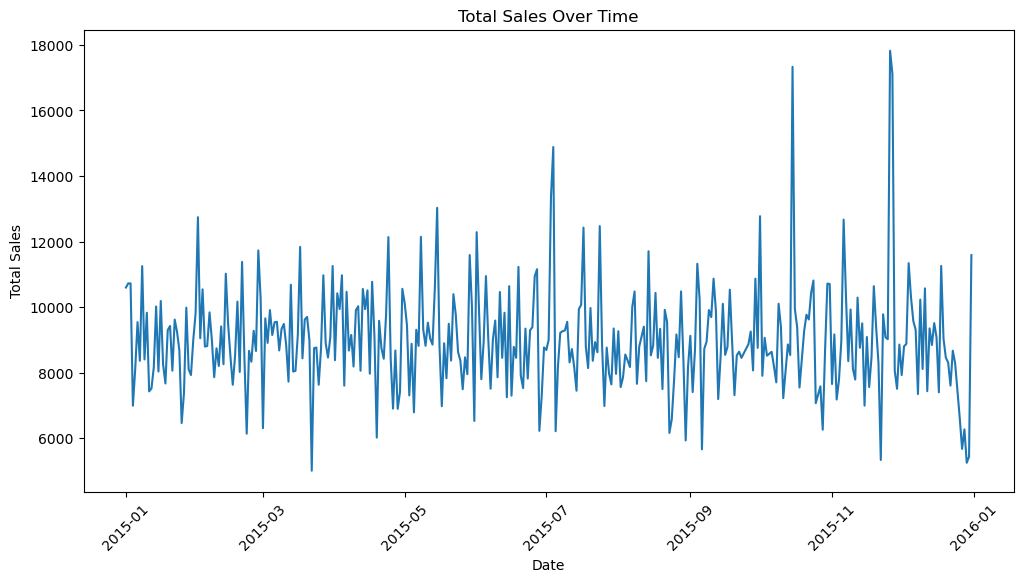

In [195]:
sales_over_time = merged_data.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

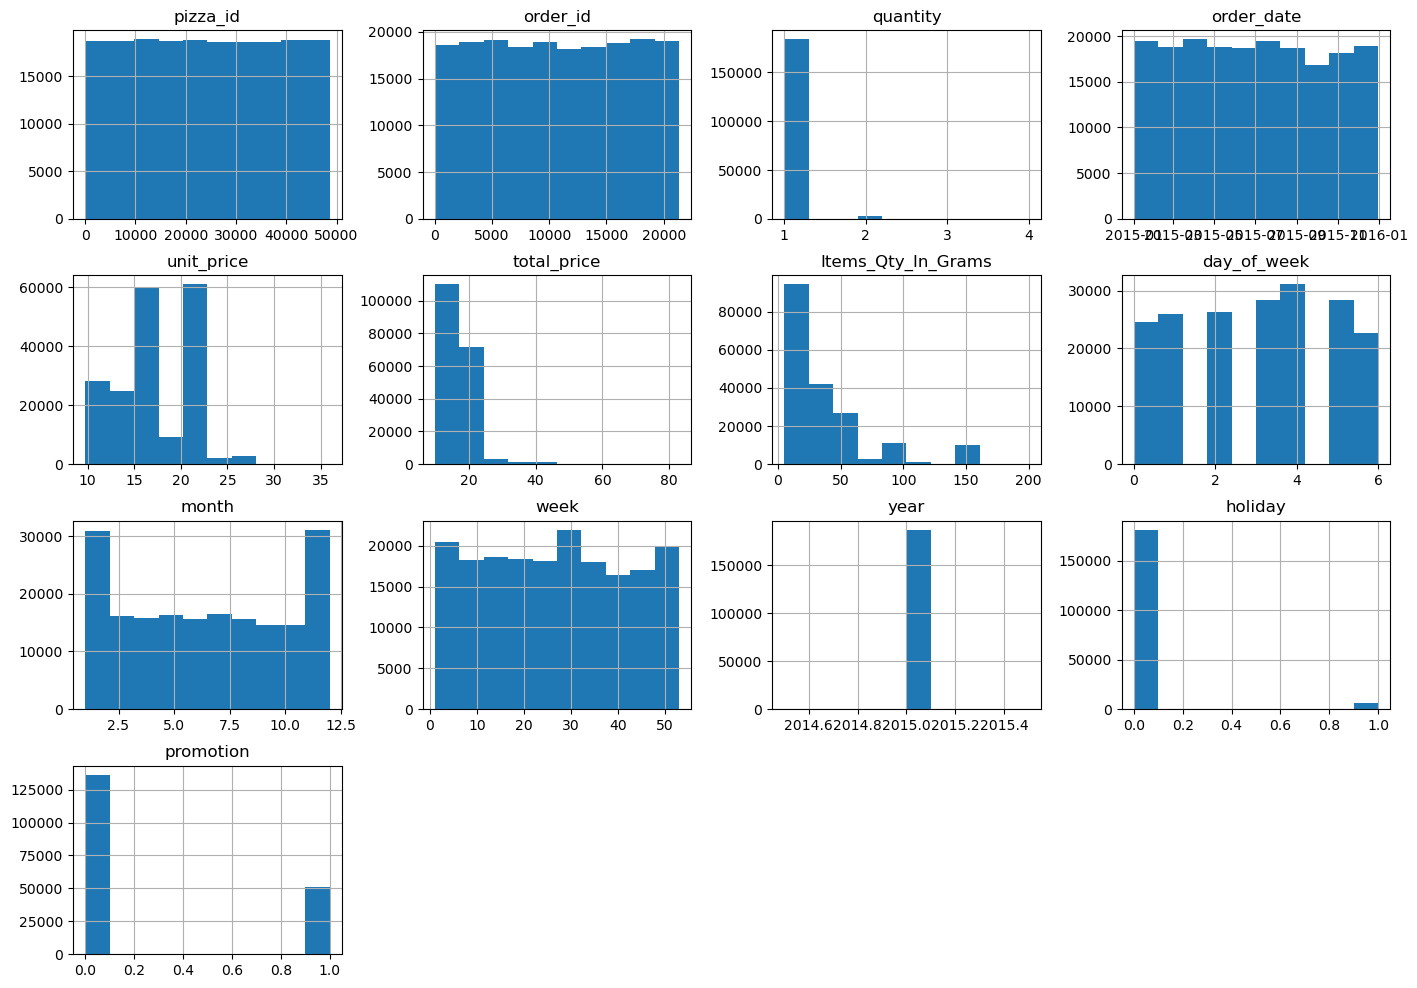

In [207]:
merged_data.hist(figsize=(17,12))  
plt.show()

**Top selling pizza**

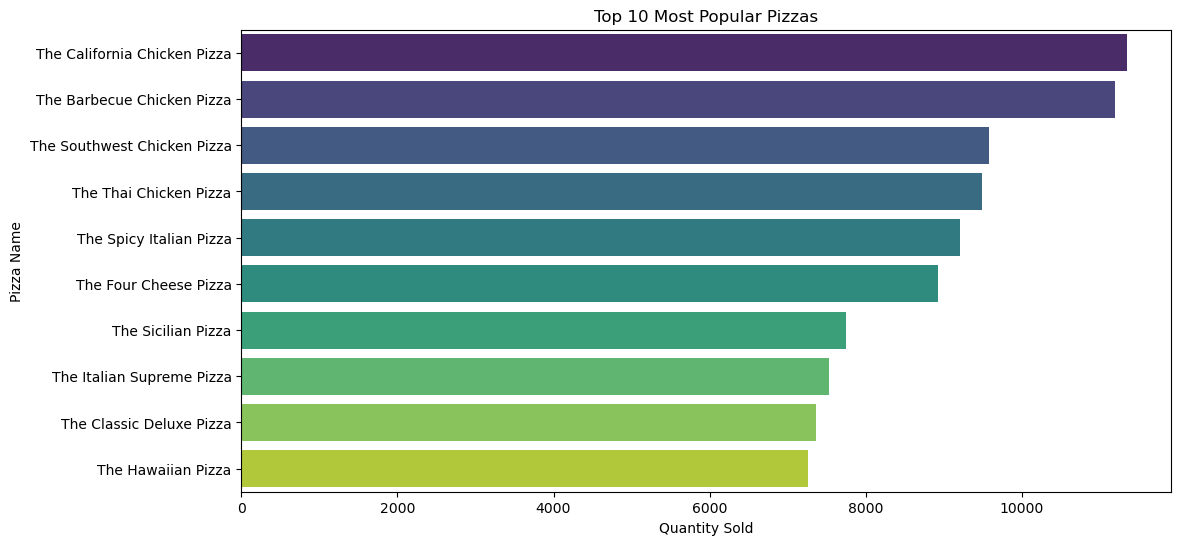

In [210]:
pizza_sales = merged_data.groupby('pizza_name')['quantity'].sum().reset_index()
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

**Sales by Pizza Size and Category**

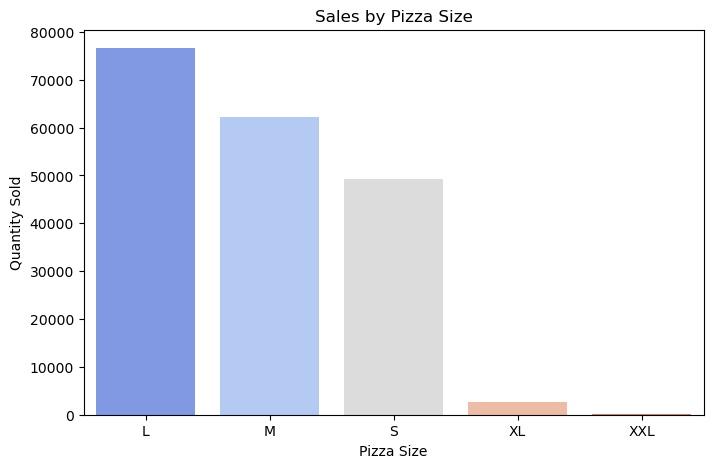

In [217]:
size_sales = merged_data.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

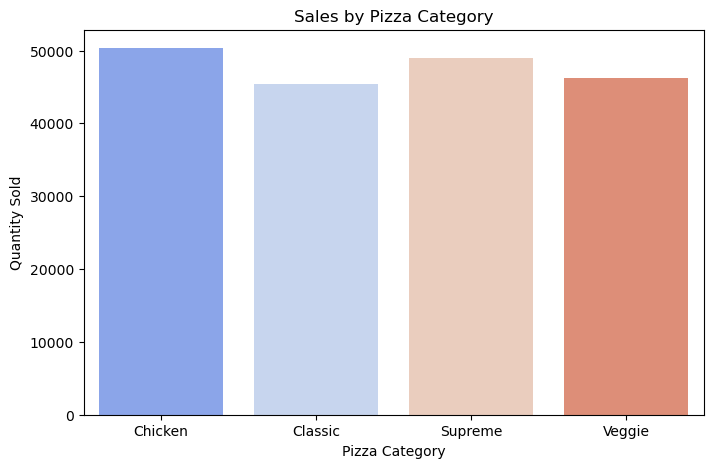

In [219]:
category_sales = merged_data.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

**Seasonal Sales Trends and Patterns**

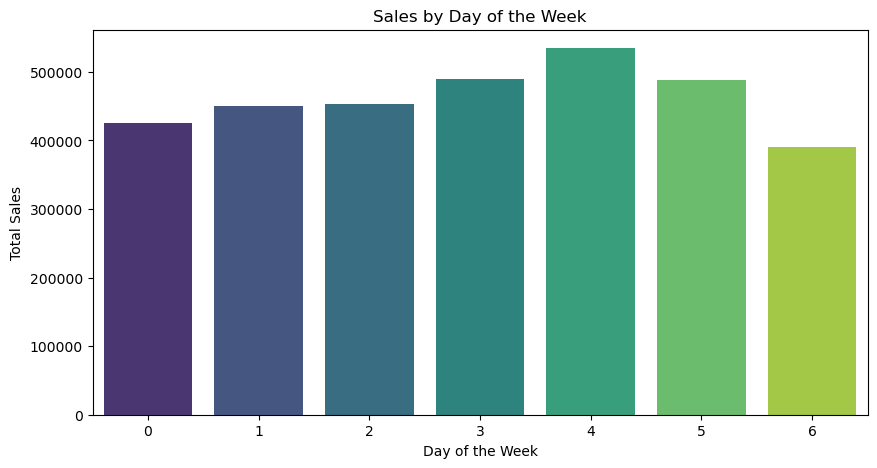

In [224]:
sales_by_day = merged_data.groupby('day_of_week')['total_price'].sum().reset_index()
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

**Sales by Month**

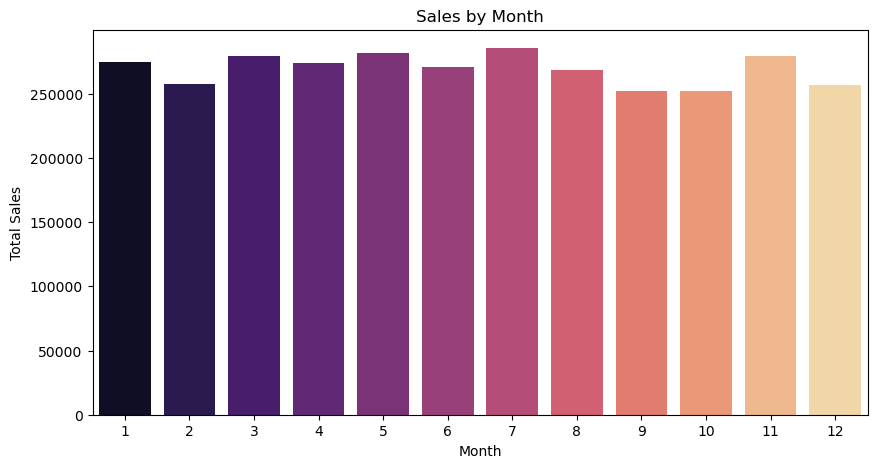

In [227]:
sales_by_month = merged_data.groupby('month')['total_price'].sum().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

**Correlation Analysis of Sales Metrics**

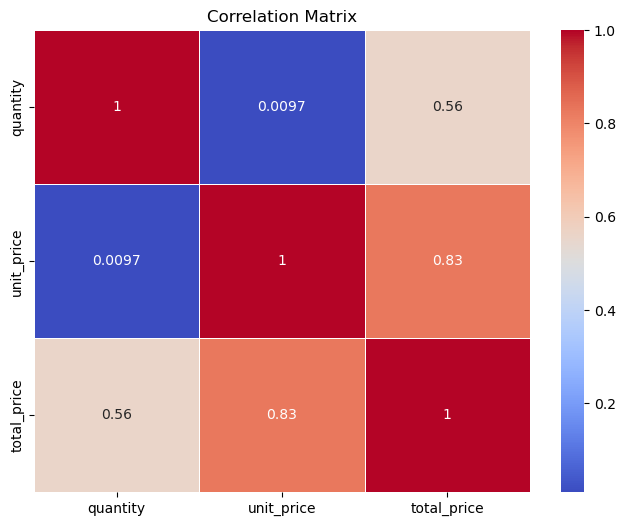

In [230]:
corr_matrix = merged_data[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

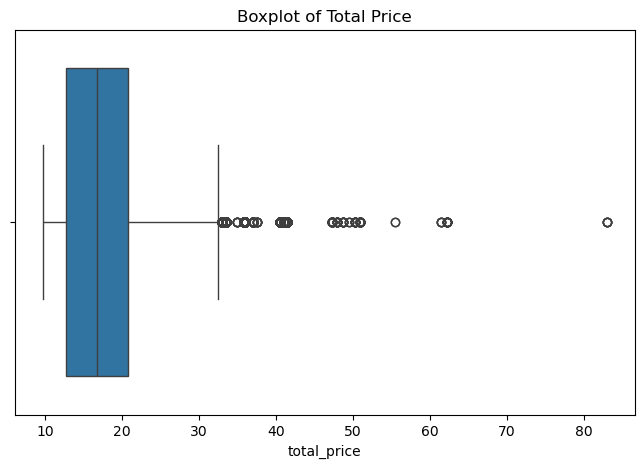

In [232]:
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_data, x='total_price')
plt.title('Boxplot of Total Price')
plt.show()

**Sales during holidays vs non-holidays**

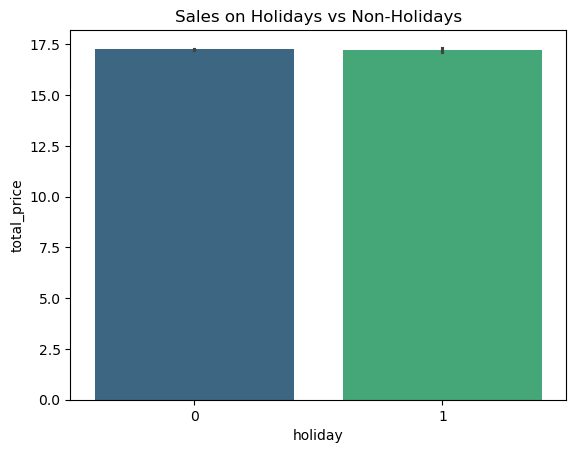

In [235]:
sns.barplot(x='holiday', y='total_price', data=merged_data, palette='viridis')
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

**Sales during promotions vs non-promotions**

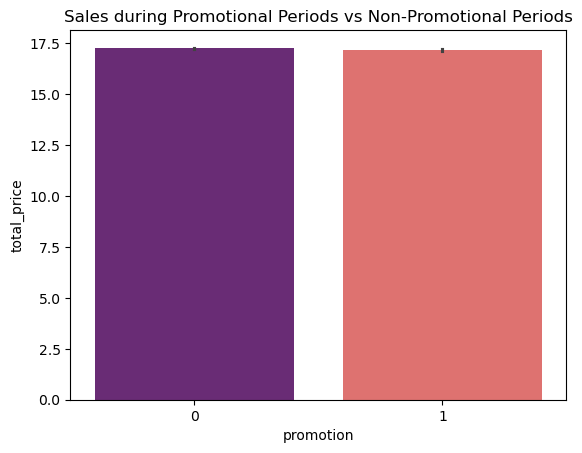

In [238]:
sns.barplot(x='promotion', y='total_price', data=merged_data, palette='magma')
plt.title('Sales during Promotional Periods vs Non-Promotional Periods')
plt.show()

Model Selection

In [245]:
!pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


In [243]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


**ARIMA Model**

In [262]:
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

In [264]:
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

In [266]:
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

In [268]:
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

Best ARIMA Model MAPE: 0.1895, Best Parameters: (3, 0, 3)


In [270]:
arima_predictions = pd.Series(arima_predictions, index=test.index)

In [278]:
print(arima_predictions)

order_date
2015-10-19    3363.814990
2015-10-26    3536.867093
2015-11-02    3483.513170
2015-11-09    3604.041357
2015-11-16    3532.700860
2015-11-23    3640.393547
2015-11-30    3559.652135
2015-12-07    3660.301283
2015-12-14    3574.431053
2015-12-21    3671.198649
2015-12-28    3582.540158
Name: predicted_mean, dtype: float64


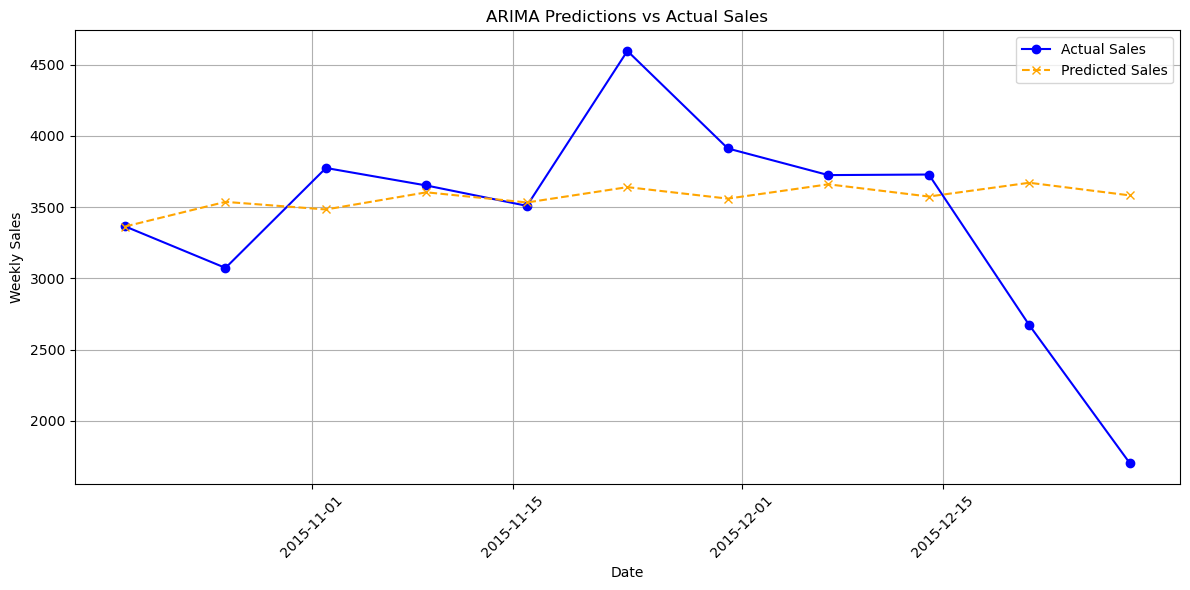

In [280]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**SARIMA (Seasonal ARIMA)**

In [285]:
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

In [287]:
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

In [289]:
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

In [293]:
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape

In [295]:
sarima_predictions, sarima_mape_score = best_sarima_model(train, test)

Best SARIMA Model MAPE: 0.1849


In [297]:
sarima_predictions = pd.Series(sarima_predictions, index=test.index)
print(sarima_predictions)

order_date
2015-10-19    3251.125624
2015-10-26    3647.292267
2015-11-02    3407.561473
2015-11-09    2750.099062
2015-11-16    3590.353369
2015-11-23    3084.831400
2015-11-30    3327.425464
2015-12-07    3155.896999
2015-12-14    3475.639785
2015-12-21    3266.273812
2015-12-28    2592.941711
Name: predicted_mean, dtype: float64


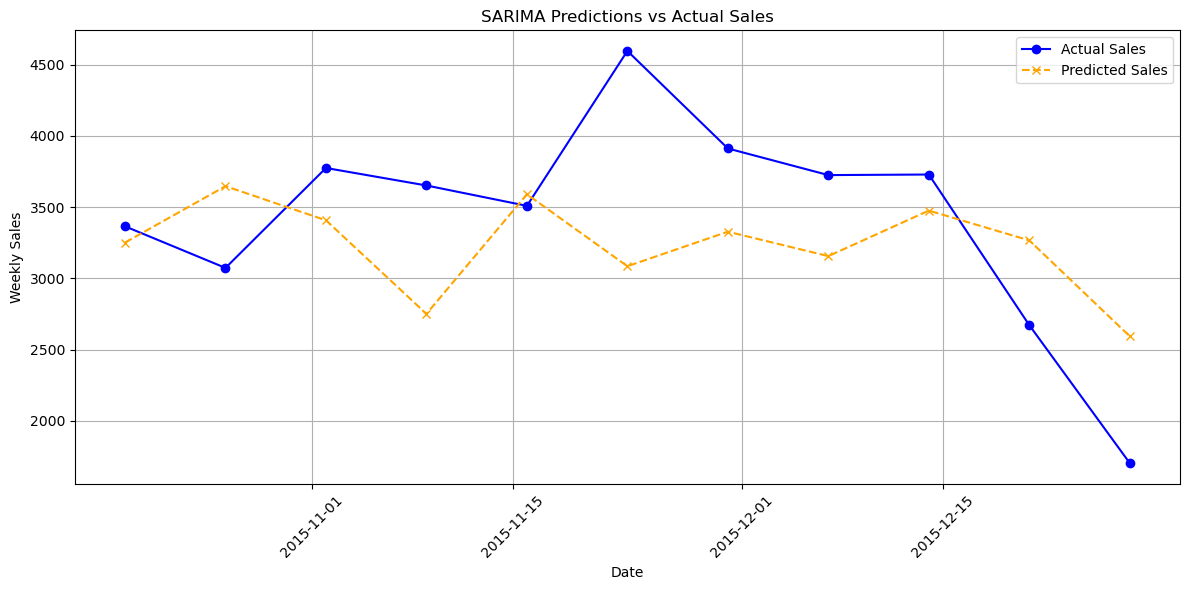

In [299]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**Prophet (Developed by Facebook)**

In [302]:
!pip install prophet

Defaulting to user installation because normal site-packages is not writeable


In [304]:
daily_sales['order_date'] = pd.to_datetime(daily_sales['order_date'])

In [306]:
prophet_data = daily_sales.rename(columns={'order_date': 'ds', 'quantity': 'y'})

In [308]:
prophet_model = Prophet()
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(prophet_data)

12:23:48 - cmdstanpy - INFO - Chain [1] start processing
12:23:49 - cmdstanpy - INFO - Chain [1] done processing


In [310]:
future_dates = prophet_model.make_future_dataframe(periods=7)
prophet_forecast = prophet_model.predict(future_dates)

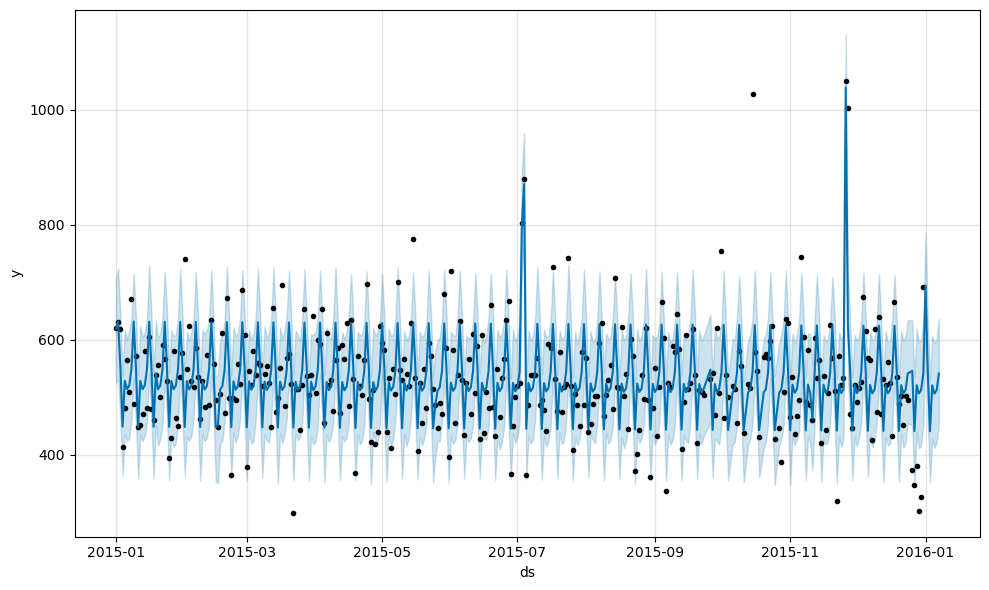

In [312]:
fig = prophet_model.plot(prophet_forecast)

Pizza sales by week

In [319]:
def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y'] 
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales_for_prophet(pizza_sales)

In [321]:
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

In [323]:
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

In [325]:
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)
    
    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values
    prophet_mape = mape(test['y'].values, predictions)
    
    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

In [327]:
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

12:34:45 - cmdstanpy - INFO - Chain [1] start processing
12:34:45 - cmdstanpy - INFO - Chain [1] done processing


Best Prophet Model MAPE: 0.1962


In [329]:
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])
print(prophet_predictions)

ds
2015-10-19    3619.506283
2015-10-26    3618.034527
2015-11-02    3616.562771
2015-11-09    3615.091015
2015-11-16    3613.619259
2015-11-23    3612.147503
2015-11-30    3610.675747
2015-12-07    3609.203991
2015-12-14    3607.732235
2015-12-21    3606.260479
2015-12-28    3604.788723
dtype: float64


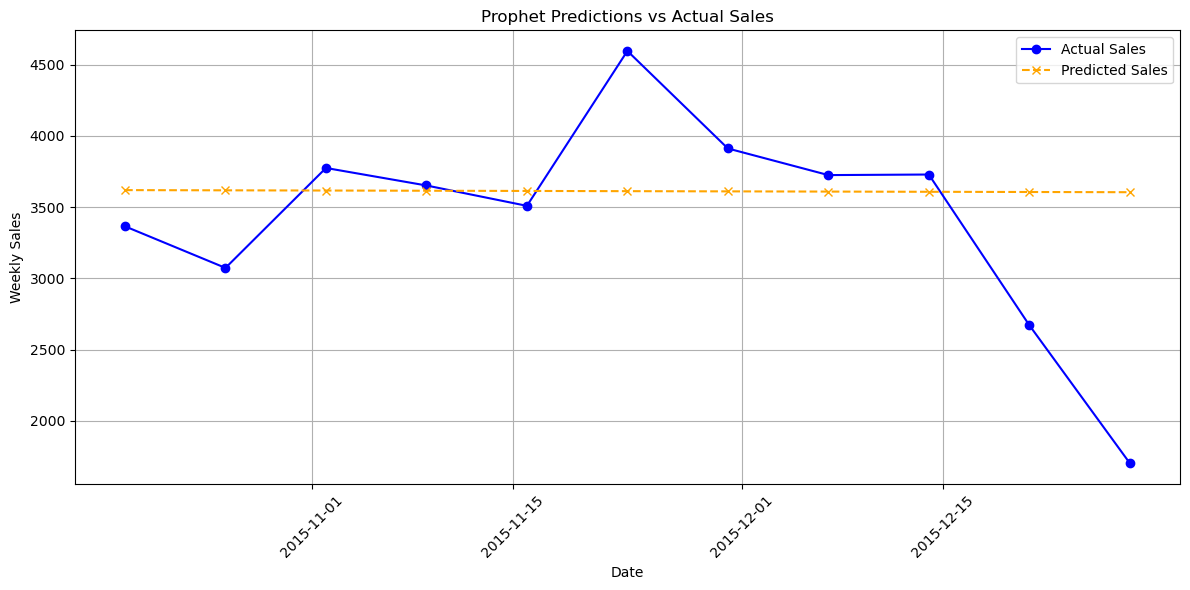

In [331]:
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**Regression Model**

In [334]:
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

In [336]:
def create_regression_features(df):
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df
pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

In [338]:
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

In [340]:
X_train = train[['week_of_year', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week_of_year', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

In [342]:
def best_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    regression_mape = mape(y_test, predictions)
    
    print(f"Best Regression Model MAPE: {regression_mape:.4f}")
    return predictions, regression_mape

In [344]:
regression_predictions, regression_mape_score = best_regression_model(X_train, y_train, X_test, y_test)

Best Regression Model MAPE: 0.1911


In [346]:
regression_predictions = pd.Series(regression_predictions, index=test['order_date'])
print(regression_predictions)

order_date
2015-10-19    3545.287304
2015-10-26    3530.562085
2015-11-02    3552.361183
2015-11-09    3537.635964
2015-11-16    3522.910745
2015-11-23    3508.185526
2015-11-30    3493.460307
2015-12-07    3515.259404
2015-12-14    3500.534185
2015-12-21    3485.808966
2015-12-28    3471.083747
dtype: float64


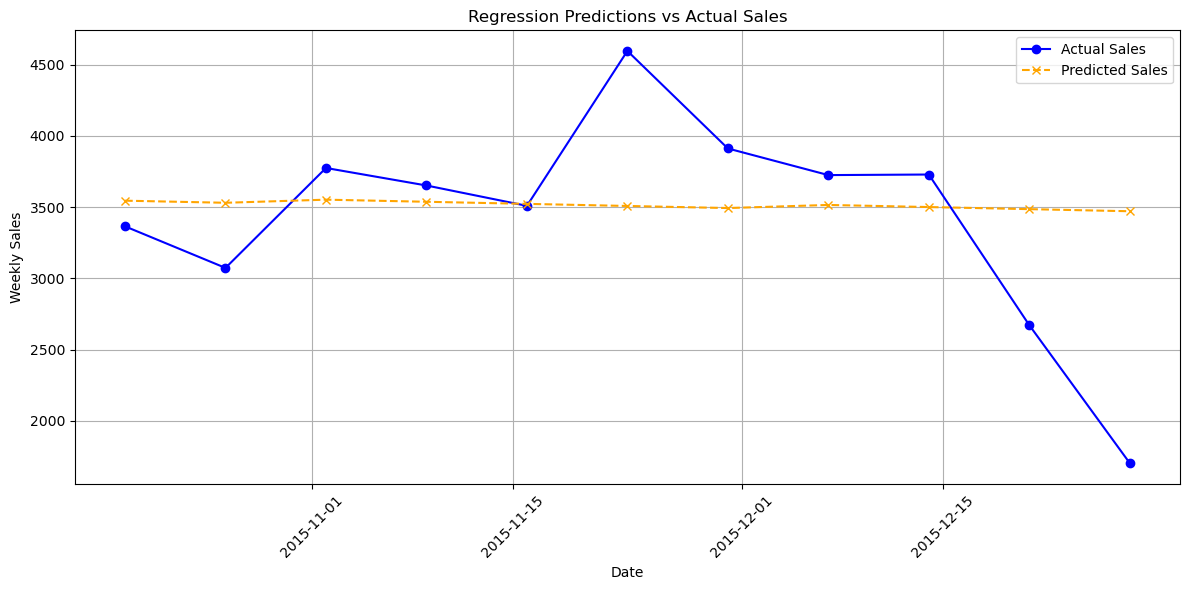

In [348]:
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'], y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(regression_predictions.index, regression_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

**LSTM model**

In [351]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable


In [353]:
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(pizza_sales)

In [355]:
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

In [357]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

In [359]:
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

In [361]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [363]:
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)
    
    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

In [365]:
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Best LSTM Model MAPE: 0.2355


In [367]:
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])
print(lstm_predictions)

order_date
2015-11-09    3457.608887
2015-11-16    3512.692627
2015-11-23    3658.121094
2015-11-30    3801.805908
2015-12-07    3898.435059
2015-12-14    4039.098389
2015-12-21    3761.650635
2015-12-28    3504.364990
dtype: float32


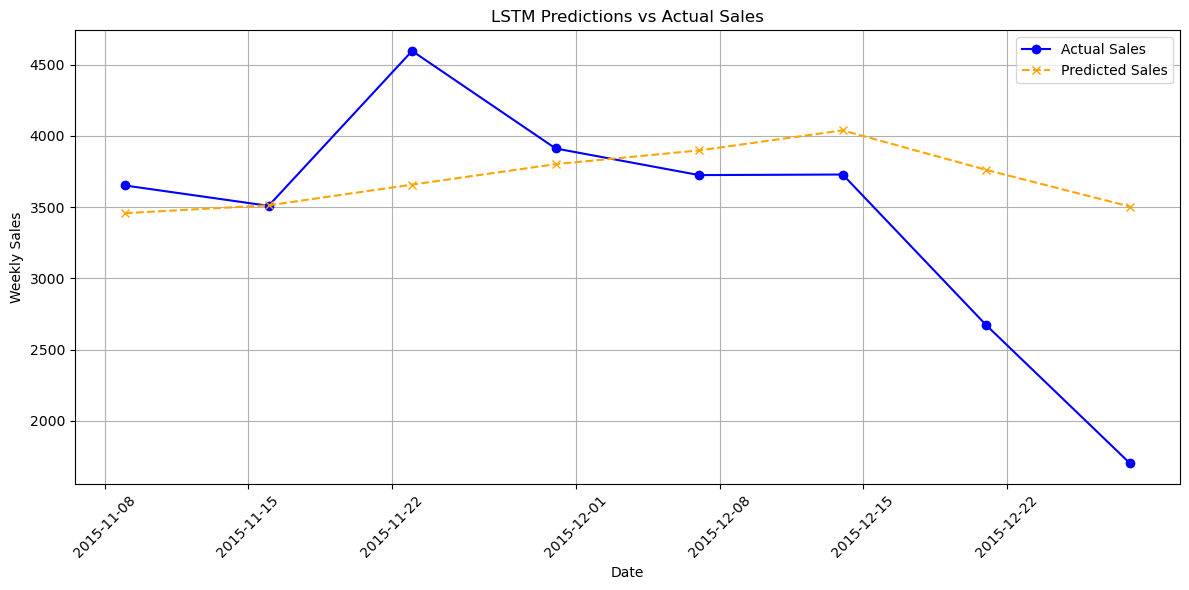

In [369]:
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

ARIMA Model forecasted sales for the week

# Forecasted sales for the week

**ARIMA Model forecasted sales for the week**

In [392]:
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

def forecast_sales_per_pizza_type_arima(pizza_type, train, periods=1):
    model = ARIMA(train, order=(1, 1, 1))
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

def forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}

    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        pizza_type, forecast = forecast_sales_per_pizza_type_arima(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

next_week_pizza_sales_forecasts_arima, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_arima(pizza_sales_weekly_by_pizza, periods=1)

print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_arima.items():
    forecast = int(forecast[0])
    next_week_pizza_sales_forecasts_arima[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 92 pizzas
bbq_ckn_m: 91 pizzas
bbq_ckn_s: 27 pizzas
big_meat_s: 107 pizzas
brie_carre_s: 37 pizzas
calabrese_m: 43 pizzas
calabrese_s: 8 pizzas
cali_ckn_l: 80 pizzas
cali_ckn_m: 81 pizzas
cali_ckn_s: 39 pizzas
ckn_alfredo_l: 14 pizzas
ckn_alfredo_m: 61 pizzas
ckn_alfredo_s: 9 pizzas
ckn_pesto_l: 31 pizzas
ckn_pesto_m: 21 pizzas
ckn_pesto_s: 15 pizzas
classic_dlx_l: 26 pizzas
classic_dlx_m: 72 pizzas
classic_dlx_s: 46 pizzas
five_cheese_l: 56 pizzas
four_cheese_l: 114 pizzas
four_cheese_m: 45 pizzas
green_garden_l: 10 pizzas
green_garden_m: 25 pizzas
green_garden_s: 46 pizzas
hawaiian_l: 50 pizzas
hawaiian_m: 24 pizzas
hawaiian_s: 52 pizzas
ital_cpcllo_l: 55 pizzas
ital_cpcllo_m: 30 pizzas
ital_cpcllo_s: 23 pizzas
ital_supr_l: 52 pizzas
ital_supr_m: 66 pizzas
ital_supr_s: 14 pizzas
ital_veggie_l: 20 pizzas
ital_veggie_m: 36 pizzas
ital_veggie_s: 16 pizzas
mediterraneo_l: 36 pizzas
mediterraneo_m: 23 pizzas
mediterraneo_s

**SARIMA Model forecasted sales for the week**

In [395]:
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(pizza_sales)

def forecast_sales_per_pizza_type(pizza_type, train, periods=1):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
    model_fit = model.fit(disp=False)
    
    forecast = model_fit.forecast(steps=periods)
    return pizza_type, forecast.tolist()

def forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]
        
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']
        pizza_type, forecast = forecast_sales_per_pizza_type(pizza_type, train, periods)

        if forecast:
            pizza_type_forecasts[pizza_type] = forecast[0]  # Access the first value of the forecast list

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

next_week_pizza_sales_forecasts, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type(pizza_sales_weekly_by_pizza, periods=1)

print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")

total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts.items():
    forecast = int(forecast)
    next_week_pizza_sales_forecasts[pizza_type]=forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 82 pizzas
bbq_ckn_m: 95 pizzas
bbq_ckn_s: 39 pizzas
big_meat_s: 89 pizzas
brie_carre_s: 56 pizzas
calabrese_m: 40 pizzas
calabrese_s: 6 pizzas
cali_ckn_l: 83 pizzas
cali_ckn_m: 56 pizzas
cali_ckn_s: 38 pizzas
ckn_alfredo_l: 9 pizzas
ckn_alfredo_m: 58 pizzas
ckn_alfredo_s: 11 pizzas
ckn_pesto_l: 31 pizzas
ckn_pesto_m: 14 pizzas
ckn_pesto_s: 14 pizzas
classic_dlx_l: 19 pizzas
classic_dlx_m: 72 pizzas
classic_dlx_s: 39 pizzas
five_cheese_l: 55 pizzas
four_cheese_l: 149 pizzas
four_cheese_m: 44 pizzas
green_garden_l: 2 pizzas
green_garden_m: 28 pizzas
green_garden_s: 46 pizzas
hawaiian_l: 48 pizzas
hawaiian_m: 20 pizzas
hawaiian_s: 46 pizzas
ital_cpcllo_l: 60 pizzas
ital_cpcllo_m: 37 pizzas
ital_cpcllo_s: 26 pizzas
ital_supr_l: 61 pizzas
ital_supr_m: 49 pizzas
ital_supr_s: 3 pizzas
ital_veggie_l: 16 pizzas
ital_veggie_m: 25 pizzas
ital_veggie_s: 16 pizzas
mediterraneo_l: 37 pizzas
mediterraneo_m: 29 pizzas
mediterraneo_s: 1

**Prophet Evaluation**

In [398]:
def forecast_sales_per_pizza_type_prophet(pizza_type, train, periods=1):
    # Prepare the data for Prophet
    train_prophet = train.reset_index().rename(columns={'week': 'ds', 'quantity': 'y'})
    
    model = Prophet()
    model.fit(train_prophet)

    future = model.make_future_dataframe(periods=periods)
    
    forecast = model.predict(future)
    return pizza_type, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(periods)

def forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza, periods=7):
    pizza_type_forecasts = {}

    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=1)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]

        pizza_type, forecast = forecast_sales_per_pizza_type_prophet(pizza_type, train, periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast['yhat'].sum()  # Total forecasted sales for the week
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, next_week_start, next_week_end

next_week_pizza_sales_forecasts_prophet, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_prophet(pizza_sales_weekly_by_pizza)

print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = sum(next_week_pizza_sales_forecasts_prophet.values())

for pizza_type, forecast in next_week_pizza_sales_forecasts_prophet.items():
    print(f'{pizza_type}: {int(forecast)} pizzas')

print(f"Total quantity of units sold in the predicted week: {int(total_forecasted_quantity)} pizzas")

13:10:49 - cmdstanpy - INFO - Chain [1] start processing
13:10:49 - cmdstanpy - INFO - Chain [1] done processing
13:10:49 - cmdstanpy - INFO - Chain [1] start processing
13:10:49 - cmdstanpy - INFO - Chain [1] done processing
13:10:49 - cmdstanpy - INFO - Chain [1] start processing
13:10:49 - cmdstanpy - INFO - Chain [1] done processing
13:10:50 - cmdstanpy - INFO - Chain [1] start processing
13:10:50 - cmdstanpy - INFO - Chain [1] done processing
13:10:50 - cmdstanpy - INFO - Chain [1] start processing
13:10:50 - cmdstanpy - INFO - Chain [1] done processing
13:10:50 - cmdstanpy - INFO - Chain [1] start processing
13:10:50 - cmdstanpy - INFO - Chain [1] done processing
13:10:50 - cmdstanpy - INFO - Chain [1] start processing
13:10:50 - cmdstanpy - INFO - Chain [1] done processing
13:10:50 - cmdstanpy - INFO - Chain [1] start processing
13:10:51 - cmdstanpy - INFO - Chain [1] done processing
13:10:51 - cmdstanpy - INFO - Chain [1] start processing
13:10:51 - cmdstanpy - INFO - Chain [1]

Forecasted sales for the week 2016-01-04 to 2016-01-10:
bbq_ckn_l: 607 pizzas
bbq_ckn_m: 658 pizzas
bbq_ckn_s: 187 pizzas
big_meat_s: 766 pizzas
brie_carre_s: 275 pizzas
calabrese_m: 309 pizzas
calabrese_s: 55 pizzas
cali_ckn_l: 603 pizzas
cali_ckn_m: 563 pizzas
cali_ckn_s: 279 pizzas
ckn_alfredo_l: 111 pizzas
ckn_alfredo_m: 450 pizzas
ckn_alfredo_s: 70 pizzas
ckn_pesto_l: 218 pizzas
ckn_pesto_m: 165 pizzas
ckn_pesto_s: 149 pizzas
classic_dlx_l: 185 pizzas
classic_dlx_m: 520 pizzas
classic_dlx_s: 323 pizzas
five_cheese_l: 379 pizzas
four_cheese_l: 862 pizzas
four_cheese_m: 304 pizzas
green_garden_l: 77 pizzas
green_garden_m: 166 pizzas
green_garden_s: 362 pizzas
hawaiian_l: 385 pizzas
hawaiian_m: 208 pizzas
hawaiian_s: 366 pizzas
ital_cpcllo_l: 417 pizzas
ital_cpcllo_m: 180 pizzas
ital_cpcllo_s: 153 pizzas
ital_supr_l: 391 pizzas
ital_supr_m: 473 pizzas
ital_supr_s: 105 pizzas
ital_veggie_l: 94 pizzas
ital_veggie_m: 239 pizzas
ital_veggie_s: 98 pizzas
mediterraneo_l: 255 pizzas
mediter

**Model Evaluation**

In [401]:
import pandas as pd
model_performance = {
    'Model': ['SARIMA', 'ARIMA', 'Regression', 'Prophet', 'LSTM'],
    'MAPE': [0.1849, 0.1896, 0.1911, 0.1962, 0.2404]
}
df_performance = pd.DataFrame(model_performance)
df_performance['Rank'] = df_performance['MAPE'].rank()
df_performance = df_performance.sort_values('MAPE', ascending=True)
df_performance['Best/Worst'] = df_performance['MAPE'].apply(lambda x: 'Best' if x == df_performance['MAPE'].min() else 'Worst' if x == df_performance['MAPE'].max() else '')
df_performance

,Model,MAPE,Rank,Best/Worst
0,SARIMA,0.1849,1.0,Best
1,ARIMA,0.1896,2.0,
2,Regression,0.1911,3.0,
3,Prophet,0.1962,4.0,
4,LSTM,0.2404,5.0,Worst


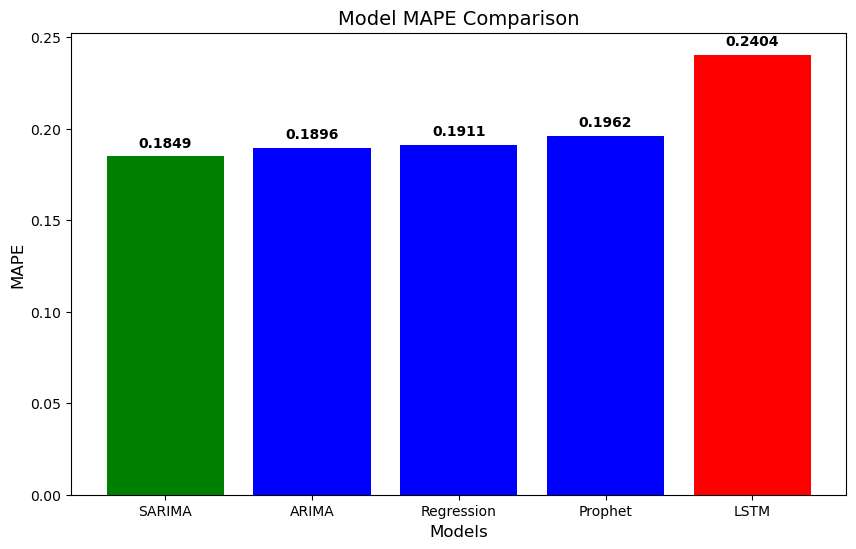

In [403]:
import matplotlib.pyplot as plt
models = ['SARIMA', 'ARIMA', 'Regression', 'Prophet', 'LSTM']
mapes = [0.1849, 0.1896, 0.1911, 0.1962, 0.2404]

plt.figure(figsize=(10,6))
plt.bar(models, mapes, color=['green', 'blue', 'blue', 'blue', 'red'])
plt.title('Model MAPE Comparison', fontsize=14)
plt.xlabel('Models', fontsize=12)
plt.ylabel('MAPE', fontsize=12)

for i, v in enumerate(mapes):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')
plt.show()

**SARIMA Evaluation**

In [426]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          quantity   No. Observations:                   42
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -249.196
Date:                           Sun, 24 Nov 2024   AIC                            508.391
Time:                                   13:21:56   BIC                            516.023
Sample:                               12-29-2014   HQIC                           510.994
                                    - 10-12-2015                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3901      0.258     -1.514      0.130      -0.895       0.115
ma.L1         -0.4667      0.256     -1.826

In [428]:
auto_model = auto_arima(train, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[7]             : AIC=511.689, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=514.308, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=505.442, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=505.959, Time=0.05 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=505.737, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=506.854, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=507.009, Time=0.08 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=505.011, Time=0.06 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=507.009, Time=0.10 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=515.380, Time=0.05 sec
 ARIMA(2,1,0)(0,1,1)[7]             : AIC=506.879, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=506.392, Time=0.08 sec
 ARIMA(2,1,1)(0,1,1)[7]             : AIC=508.027, Time=0.10 sec
 ARIMA(1,1,0)(0,1,1)[7] intercept   : AIC=505.395, 

In [441]:
import pickle 
model_filename = 'best_sarima_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(auto_model, file)
print(f"Model saved as {model_filename}")

Model saved as best_sarima_model.pkl


In [443]:
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
print("Model loaded successfully.")

Model loaded successfully.


**Final Results and Predictions**

In [447]:
model_filename = 'best_sarima_model.pkl'
with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)
def forecast_sales(loaded_model, periods):
    forecast = loaded_model.predict(n_periods=periods)
    return forecast

forecasted_sales = forecast_sales(loaded_model, periods=7)
print(forecasted_sales)

2015-10-19    3213.580075
2015-10-26    3760.607880
2015-11-02    3370.263291
2015-11-09    2900.604061
2015-11-16    3582.850126
2015-11-23    3194.747227
2015-11-30    3349.252534
Freq: W-MON, dtype: float64


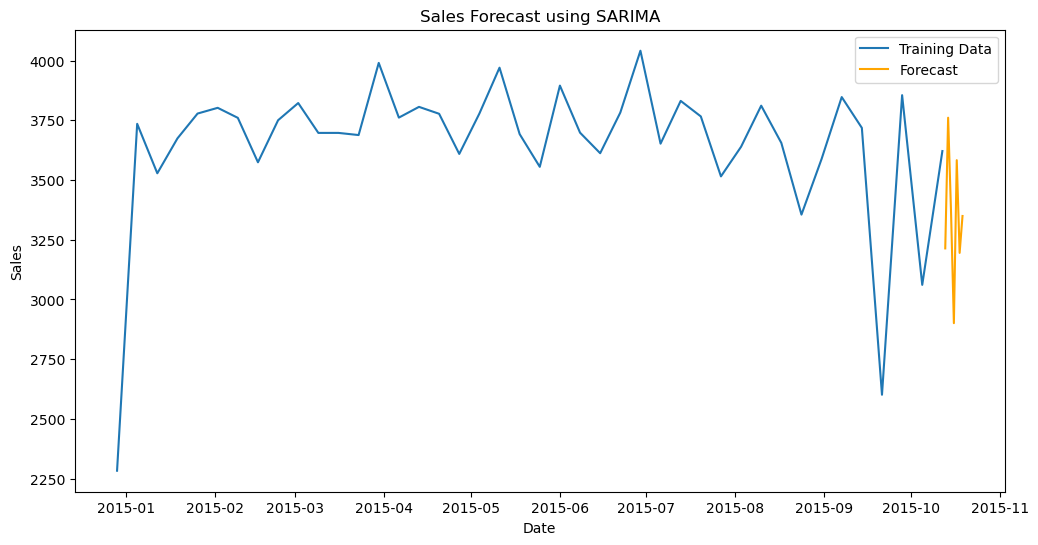

In [449]:
with open('best_sarima_model.pkl', 'rb') as file:
    best_model = pickle.load(file)
n_forecast = 7
forecast = best_model.predict(n_periods=n_forecast)
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(pd.date_range(start=train.index[-1] + pd.Timedelta(days=1), periods=n_forecast), forecast, label='Forecast', color='orange')
plt.title('Sales Forecast using SARIMA')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

In [469]:
ingredients_predicted = Ingredients_dataset.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts_arima)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
print(ingredient_totals)
ingredients_predicted

Total quantity of predicted ingredients for the following week:
{'?duja Salami': 2540.0, 'Alfredo Sauce': 1285.0, 'Anchovies': 3295.0, 'Artichokes': 10485.0, 'Arugula': 705.0, 'Asiago Cheese': 6200.0, 'Bacon': 28670.0, 'Barbecue Sauce': 2425.0, 'Barbecued Chicken': 6950.0, 'Beef Chuck Roast': 10660.0, 'Blue Cheese': 1680.0, 'Brie Carre Cheese': 1110.0, 'Calabrese Salami': 15100.0, 'Capocollo': 62100.0, 'Caramelized Onions': 592.0, 'Chicken': 80800.0, 'Chipotle Sauce': 7330.0, 'Chorizo Sausage': 5350.0, 'Cilantro': 3665.0, 'Coarse Sicilian Salami': 11480.0, 'Corn': 24540.0, 'Eggplant': 2960.0, 'Feta Cheese': 9970.0, 'Fontina Cheese': 5840.0, 'Friggitello Peppers': 635.0, 'Garlic': 23835.0, 'Genoa Salami': 8790.0, 'Goat Cheese': 12940.0, 'Gorgonzola Piccante Cheese': 5460.0, 'Gouda Cheese': 4410.0, 'Green Olives': 4745.0, 'Green Peppers': 6840.0, 'Italian Sausage': 1070.0, 'Jalapeno Peppers': 5870.0, 'Kalamata Olives': 3070.0, 'Luganega Sausage': 5740.0, 'Mozzarella Cheese': 11560.0, 'Mu

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,92,3680.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,92,1380.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,92,1840.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,92,2760.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,92,5520.0
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,33,660.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,33,660.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,33,330.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,33,495.0


In [471]:
ingredient_totals

{'?duja Salami': 2540.0,
 'Alfredo Sauce': 1285.0,
 'Anchovies': 3295.0,
 'Artichokes': 10485.0,
 'Arugula': 705.0,
 'Asiago Cheese': 6200.0,
 'Bacon': 28670.0,
 'Barbecue Sauce': 2425.0,
 'Barbecued Chicken': 6950.0,
 'Beef Chuck Roast': 10660.0,
 'Blue Cheese': 1680.0,
 'Brie Carre Cheese': 1110.0,
 'Calabrese Salami': 15100.0,
 'Capocollo': 62100.0,
 'Caramelized Onions': 592.0,
 'Chicken': 80800.0,
 'Chipotle Sauce': 7330.0,
 'Chorizo Sausage': 5350.0,
 'Cilantro': 3665.0,
 'Coarse Sicilian Salami': 11480.0,
 'Corn': 24540.0,
 'Eggplant': 2960.0,
 'Feta Cheese': 9970.0,
 'Fontina Cheese': 5840.0,
 'Friggitello Peppers': 635.0,
 'Garlic': 23835.0,
 'Genoa Salami': 8790.0,
 'Goat Cheese': 12940.0,
 'Gorgonzola Piccante Cheese': 5460.0,
 'Gouda Cheese': 4410.0,
 'Green Olives': 4745.0,
 'Green Peppers': 6840.0,
 'Italian Sausage': 1070.0,
 'Jalapeno Peppers': 5870.0,
 'Kalamata Olives': 3070.0,
 'Luganega Sausage': 5740.0,
 'Mozzarella Cheese': 11560.0,
 'Mushrooms': 25860.0,
 'Onions

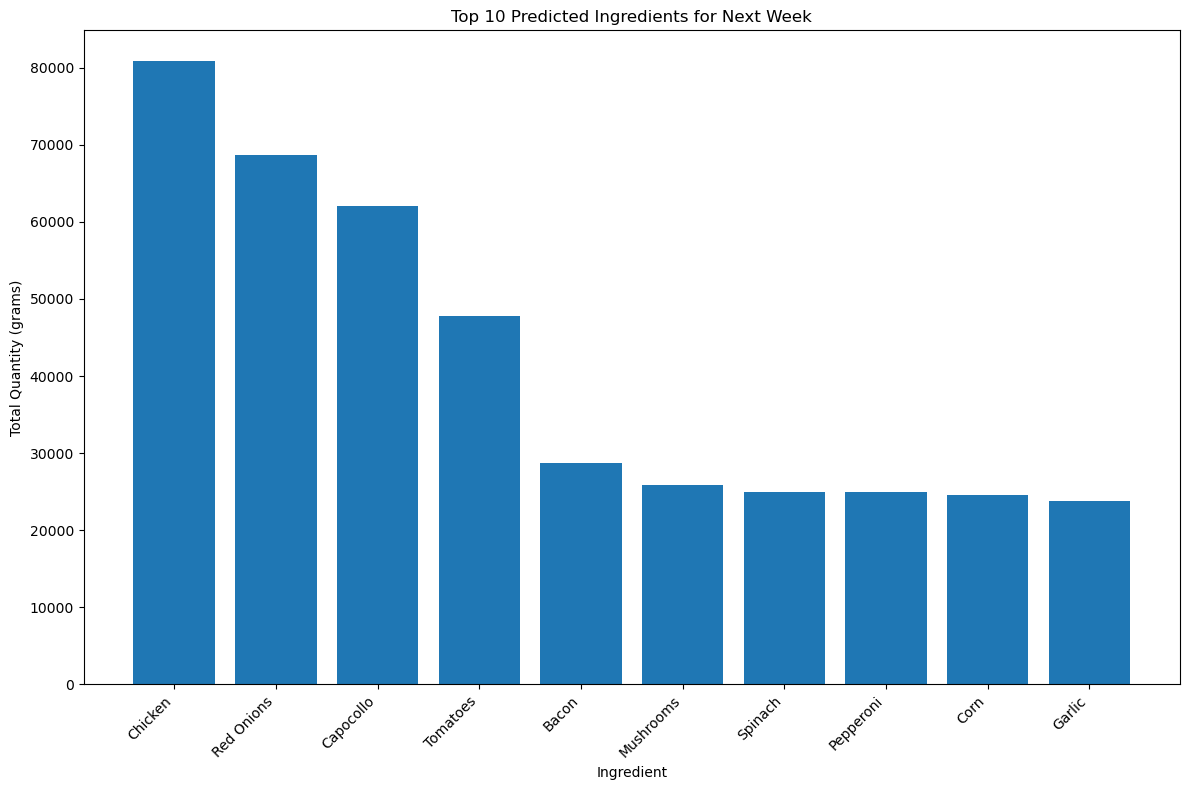

In [477]:
import pandas as pd
import matplotlib.pyplot as plt
ingredient_totals = {
    '?duja Salami': 2540.0,
    'Alfredo Sauce': 1285.0,
    'Anchovies': 3295.0,
    'Artichokes': 10485.0,
    'Arugula': 705.0,
    'Asiago Cheese': 6200.0,
    'Bacon': 28670.0,
    'Barbecue Sauce': 2425.0,
    'Barbecued Chicken': 6950.0,
    'Beef Chuck Roast': 10660.0,
    'Blue Cheese': 1680.0,
    'Brie Carre Cheese': 1110.0,
    'Calabrese Salami': 15100.0,
    'Capocollo': 62100.0,
    'Caramelized Onions': 592.0,
    'Chicken': 80800.0,
    'Chipotle Sauce': 7330.0,
    'Chorizo Sausage': 5350.0,
    'Cilantro': 3665.0,
    'Coarse Sicilian Salami': 11480.0,
    'Corn': 24540.0,
    'Eggplant': 2960.0,
    'Feta Cheese': 9970.0,
    'Fontina Cheese': 5840.0,
    'Friggitello Peppers': 635.0,
    'Garlic': 23835.0,
    'Genoa Salami': 8790.0,
    'Goat Cheese': 12940.0,
    'Gorgonzola Piccante Cheese': 5460.0,
    'Gouda Cheese': 4410.0,
    'Green Olives': 4745.0,
    'Green Peppers': 6840.0,
    'Italian Sausage': 1070.0,
    'Jalapeno Peppers': 5870.0,
    'Kalamata Olives': 3070.0,
    'Luganega Sausage': 5740.0,
    'Mozzarella Cheese': 11560.0,
    'Mushrooms': 25860.0,
    'Onions': 2870.0,
    'Oregano': 1240.0,
    'Pancetta': 3810.0,
    'Parmigiano Reggiano Cheese': 12960.0,
    'Pears': 370.0,
    'Peperoncini verdi': 1995.0,
    'Pepperoni': 24970.0,
    'Pesto Sauce': 4210.0,
    'Pineapple': 10005.0,
    'Plum Tomatoes': 3500.0,
    'Prosciutto': 1110.0,
    'Prosciutto di San Daniele': 1660.0,
    'Provolone Cheese': 1680.0,
    'Red Onions': 68680.0,
    'Red Peppers': 14475.0,
    'Ricotta Cheese': 6825.0,
    'Romano Cheese': 1680.0,
    'Sliced Ham': 3125.0,
    'Smoked Gouda Cheese': 1680.0,
    'Soppressata Salami': 7150.0,
    'Spinach': 25005.0,
    'Sun-dried Tomatoes': 1490.0,
    'Thai Sweet Chilli Sauce': 4170.0,
    'Thyme': 185.0,
    'Tomatoes': 47840.0,
    'Zucchini': 4210.0
}
ingredient_totals_df = pd.DataFrame(list(ingredient_totals.items()), columns=['Ingredient', 'Total Quantity (grams)'])
top_ingredients = ingredient_totals_df.nlargest(10, 'Total Quantity (grams)')
plt.figure(figsize=(12, 8))
plt.bar(top_ingredients['Ingredient'], top_ingredients['Total Quantity (grams)'])
plt.title('Top 10 Predicted Ingredients for Next Week')
plt.xlabel('Ingredient')
plt.ylabel('Total Quantity (grams)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [481]:
ingredient_totals_df = pd.DataFrame(ingredient_totals.items(), columns=['Ingredient', 'Total Quantity (grams)'])
ingredient_totals_df.to_csv('predicted_ingredient_totals.csv', index=False)
print("Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'")

Predicted ingredient totals saved to 'predicted_ingredient_totals.csv'


In [483]:
predicted_ingredient_totals = pd.read_csv('predicted_ingredient_totals.csv')
predicted_ingredient_totals

,Ingredient,Total Quantity (grams)
0,?duja Salami,2540.0
1,Alfredo Sauce,1285.0
2,Anchovies,3295.0
3,Artichokes,10485.0
4,Arugula,705.0
...,...,...
59,Sun-dried Tomatoes,1490.0
60,Thai Sweet Chilli Sauce,4170.0
61,Thyme,185.0
62,Tomatoes,47840.0


In [485]:
predicted_ingredient_totals = pd.read_csv('predicted_ingredient_totals.csv')
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.colheader_justify', 'left')  
print(predicted_ingredient_totals)


   Ingredient                   Total Quantity (grams)
0                 ?duja Salami   2540.0               
1                Alfredo Sauce   1285.0               
2                    Anchovies   3295.0               
3                   Artichokes  10485.0               
4                      Arugula    705.0               
5                Asiago Cheese   6200.0               
6                        Bacon  28670.0               
7               Barbecue Sauce   2425.0               
8            Barbecued Chicken   6950.0               
9             Beef Chuck Roast  10660.0               
10                 Blue Cheese   1680.0               
11           Brie Carre Cheese   1110.0               
12            Calabrese Salami  15100.0               
13                   Capocollo  62100.0               
14          Caramelized Onions    592.0               
15                     Chicken  80800.0               
16              Chipotle Sauce   7330.0               
17        